In [1]:
import torch
import torchaudio

In [2]:
from helper import get_initial_table, get_final_table

## 语音数据集预处理

- 将连续的多音节重叠到一起，划分单个汉字的时间
- 延长发音需要标注出来，确定为延长，方便之后生成

In [3]:
initial_table = get_initial_table()

In [4]:
sample_rate = 22050

In [5]:
def print_all(x): 
    for s in x:
        if len(s) == 1 and isinstance(s, torch.Tensor):
            print(s.shape)
            continue
        print(len(s), s)

In [6]:
def get_transcriptions(path):
    with open(path) as f:
        lines = f.read().split('\n')
        if (lines[-1]==''):
            lines = lines[:-1]
        return lines

In [7]:
path = '../data/opencpop/segments/'
lines = get_transcriptions(path+'train.txt')
len(lines)

3550

In [8]:
def get_audio(id, path, sr = sample_rate):
    wav_path = path+'wavs/'+str(id)+'.wav'
    waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
    if sample_rate != sr:
        waveform = torchaudio.functional.resample(waveform[0].unsqueeze(0), sample_rate, sr)
    return waveform

def parser_line(line):
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = line.split('|')
    phoneme = phoneme.split(' ')
    note = note.split(' ')
    note_duration = [float(i) for i in note_duration.split(' ')]
    phoneme_duration = [float(i) for i in phoneme_duration.split(' ')]
    slur_note = [int(i) for i in slur_note.split(' ')]
    assert len(phoneme) == len(note_duration) and len(phoneme_duration) == len(slur_note) and len(slur_note) == len(phoneme)
    return id, text, phoneme, note, note_duration, phoneme_duration, slur_note

看下一共用到了多少元音辅音

In [9]:
phoneme_set = set()
note_set = set()
min_note_duration = 100
max_note_duration = -1
note_durations = []
for line in lines:
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)
    phoneme_set.update(set(phoneme))
    note_set.update(set(note))
    note_durations.extend(note_duration)
    if max(note_duration) > max_note_duration:
        max_note_duration = max(note_duration)
        max_note_id = text
    if min(note_duration) < min_note_duration:
        min_note_duration = min(note_duration)

max_note_id

'到现在'

我们需要依赖下图进行时间分辨率量化embedding。

在0-1之间，密集，所以需要精细的分辨率，比如0.01，之后可以降低分辨率，比如改为0.2

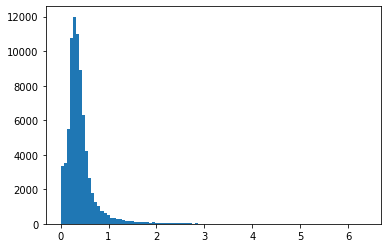

In [10]:
import matplotlib.pyplot as plt
plt.hist(note_durations, bins = 100)
plt.show()

In [11]:
print_all([phoneme_set,note_set])
print(max_note_duration, min_note_duration)

60 {'ei', 'van', 'uo', 'ia', 'sh', 'ong', 'q', 'o', 'SP', 'ian', 'w', 'an', 'g', 'eng', 'er', 'vn', 'iong', 'i', 'c', 'd', 'uai', 'ui', 't', 'e', 'l', 'in', 'f', 'AP', 'zh', 'j', 'iang', 's', 'iu', 'ua', 'ai', 'uan', 'ch', 'en', 'z', 'ing', 'm', 'u', 'a', 'ie', 'p', 'r', 'n', 'ao', 've', 'x', 'k', 'b', 'ang', 'y', 'ou', 'iao', 'uang', 'un', 'v', 'h'}
35 {'A#3/Bb3', 'F3', 'D#5/Eb5', 'D4', 'G#4/Ab4', 'B3', 'F4', 'C5', 'F#4/Gb4', 'C4', 'B4', 'A3', 'C#5/Db5', 'A#4/Bb4', 'F#3/Gb3', 'D#4/Eb4', 'A5', 'D3', 'D5', 'F#5/Gb5', 'G#3/Ab3', 'D#3/Eb3', 'E4', 'C#3/Db3', 'C3', 'F5', 'G3', 'C#4/Db4', 'E3', 'G4', 'D2', 'C#2/Db2', 'rest', 'A4', 'E5'}
6.35453 0.0071


In [12]:
from helper import get_phoneme_labels
phoneme_labels = get_phoneme_labels()
set(phoneme_labels) - phoneme_set, phoneme_set - set(phoneme_labels)

({'-', 'iou', 'uei', 'uen', 'ueng', '|', 'ê'}, {'AP', 'SP', 'iu', 'ui', 'un'})

In [13]:
def get_transposed_phoneme_labels():
    phoneme_list = get_initial_table() + get_final_table()
    for x in ['iou', 'uei', 'uen', 'ueng', 'ê']:
        phoneme_list.remove(x)
    phoneme_list += ['iu', 'ui', 'un', 'AP', 'SP']
    return ['-', '|']+phoneme_list

In [14]:
phoneme_labels = get_transposed_phoneme_labels()
print(phoneme_labels)

['-', '|', 'b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'g', 'k', 'h', 'j', 'q', 'x', 'zh', 'ch', 'sh', 'r', 'z', 'c', 's', 'y', 'w', 'i', 'u', 'v', 'a', 'ia', 'ua', 'o', 'uo', 'e', 'ie', 've', 'ai', 'uai', 'ei', 'ao', 'iao', 'ou', 'an', 'ian', 'uan', 'van', 'en', 'in', 'vn', 'ang', 'iang', 'uang', 'eng', 'ing', 'ong', 'iong', 'er', 'iu', 'ui', 'un', 'AP', 'SP']


打一个示例

In [15]:
line = lines[5]
line

'2001000006|漂浮在一片无奈|p iao f u z ai ai ai AP SP y i i p ian ian ian w u n ai SP AP|E4 E4 F#4/Gb4 F#4/Gb4 G#4/Ab4 G#4/Ab4 A4 G#4/Ab4 rest rest E4 E4 F#4/Gb4 G#4/Ab4 G#4/Ab4 A4 G#4/Ab4 E4 E4 F#4/Gb4 F#4/Gb4 rest rest|0.185230 0.185230 0.177410 0.177410 0.193930 0.193930 0.259670 0.299340 0.215550 0.031770 0.197520 0.197520 0.165450 0.184760 0.184760 0.212290 0.246960 0.440370 0.440370 1.524950 1.524950 0.855830 0.559100|0.06011 0.12512 0.07517 0.10224 0.08603 0.1079 0.25967 0.29934 0.21555 0.03177 0.05175 0.14577 0.16545 0.0748 0.10996 0.21229 0.24696 0.09617 0.3442 0.1437 1.38125 0.85583 0.5591|0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0'

In [16]:
id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)
print_all([id, text, phoneme, note, note_duration, phoneme_duration, slur_note])

10 2001000006
7 漂浮在一片无奈
23 ['p', 'iao', 'f', 'u', 'z', 'ai', 'ai', 'ai', 'AP', 'SP', 'y', 'i', 'i', 'p', 'ian', 'ian', 'ian', 'w', 'u', 'n', 'ai', 'SP', 'AP']
23 ['E4', 'E4', 'F#4/Gb4', 'F#4/Gb4', 'G#4/Ab4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'rest', 'rest', 'E4', 'E4', 'F#4/Gb4', 'G#4/Ab4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'E4', 'E4', 'F#4/Gb4', 'F#4/Gb4', 'rest', 'rest']
23 [0.18523, 0.18523, 0.17741, 0.17741, 0.19393, 0.19393, 0.25967, 0.29934, 0.21555, 0.03177, 0.19752, 0.19752, 0.16545, 0.18476, 0.18476, 0.21229, 0.24696, 0.44037, 0.44037, 1.52495, 1.52495, 0.85583, 0.5591]
23 [0.06011, 0.12512, 0.07517, 0.10224, 0.08603, 0.1079, 0.25967, 0.29934, 0.21555, 0.03177, 0.05175, 0.14577, 0.16545, 0.0748, 0.10996, 0.21229, 0.24696, 0.09617, 0.3442, 0.1437, 1.38125, 0.85583, 0.5591]
23 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


音频文件读取测试

In [17]:
waveform = get_audio(id, path)
waveform.shape

torch.Size([1, 126791])

汉字元音辅音组合为单个汉字

In [18]:
print(get_final_table())

['i', 'u', 'v', 'a', 'ia', 'ua', 'o', 'uo', 'e', 'ie', 've', 'ai', 'uai', 'ei', 'uei', 'ao', 'iao', 'ou', 'iou', 'an', 'ian', 'uan', 'van', 'en', 'in', 'uen', 'vn', 'ang', 'iang', 'uang', 'eng', 'ing', 'ueng', 'ong', 'iong', 'er', 'ê']


In [19]:
def merge_note(text, phoneme, note, note_duration, slur_note):
    # 1. check whether the phoneme is in finals
    INITIALS = get_initial_table()
    FINALS = get_final_table()
    # is_final = [1 if p in FINALS else 0 for p in phoneme]
    phoneme = phoneme.copy()
    note = note.copy()
    note_duration = note_duration.copy()
    slur_note = slur_note.copy()
    j = -1
    text+='////////////////////'
    text_with_p = phoneme.copy()
    used_flag = False
    for i in range(len(text_with_p)):
        if text_with_p[i] in ['AP', 'SP']:
            continue
        if j==-1 or phoneme[i] in INITIALS or (phoneme[i-1] not in INITIALS and phoneme[i] != phoneme[i-1]):
            j+=1
            used_flag = False
        text_with_p[i] = text[j] if used_flag == False else '~'
        used_flag = True
    for i in range(len(phoneme)-1, 0, -1):
        if (note_duration[i] == note_duration[i-1] and phoneme[i-1] in INITIALS):
            del note_duration[i]
            del note[i]
            phoneme[i-1]=[phoneme[i-1],phoneme[i]]
            del phoneme[i]
            del text_with_p[i]
            del slur_note[i]
        elif phoneme[i] in FINALS or phoneme[i] in ['AP', 'SP']:
            phoneme[i] = [phoneme[i], '-']
    return text_with_p, phoneme, note, note_duration, slur_note

In [20]:
print_all(merge_note(text, phoneme, note, note_duration, slur_note))

16 ['漂', '浮', '在', '~', '~', 'AP', 'SP', '一', '~', '片', '~', '~', '无', '奈', 'SP', 'AP']
16 [['p', 'iao'], ['f', 'u'], ['z', 'ai'], ['ai', '-'], ['ai', '-'], ['AP', '-'], ['SP', '-'], ['y', 'i'], ['i', '-'], ['p', 'ian'], ['ian', '-'], ['ian', '-'], ['w', 'u'], ['n', 'ai'], ['SP', '-'], ['AP', '-']]
16 ['E4', 'F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'rest', 'rest', 'E4', 'F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'E4', 'F#4/Gb4', 'rest', 'rest']
16 [0.18523, 0.17741, 0.19393, 0.25967, 0.29934, 0.21555, 0.03177, 0.19752, 0.16545, 0.18476, 0.21229, 0.24696, 0.44037, 1.52495, 0.85583, 0.5591]
16 [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]


In [21]:
from dataset import SpeechDataset
from torch.utils.data import DataLoader, Dataset, random_split

In [22]:
class OpencpopDataset(SpeechDataset):

    def __init__(self, data_path, sample_rate=sample_rate, transform=None):
        super().__init__(data_path, sample_rate, transform)
        transcript_file = data_path+'transcriptions.txt'
        self.transcript = self.gen_transcript(transcript_file)
        self.dataset_file_num = len(self.transcript)
        self.threshold = 120000 # to avoid GPU memory used out
        self.batch_size = 80 # to avoid GPU memory used out
        self.split_ratio = [1000, 3]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        line = self.transcript[idx]
        id, text, phoneme, note, note_duration, phoneme_duration, slur_note = self.parser_line(line)
        waveform = self.get_audio(id)
        # text_with_p, phoneme, note, note_duration = merge_note(text, phoneme, note, note_duration)
        sample = {'audio': waveform, 'text': line}
        if self.transform:
            sample = self.transform(sample, self.sample_rate)
        return sample

    def get_audio(self, id):
        wav_path = self.data_path+'wavs/'+str(id)+'.wav'
        waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform[0].unsqueeze(0), sample_rate, self.sample_rate)
        return waveform

    def parser_line(self, line):
        id, text, phoneme, note, note_duration, phoneme_duration, slur_note = line.split('|')
        phoneme = phoneme.split(' ')
        note = note.split(' ')
        note_duration = [float(i) for i in note_duration.split(' ')]
        phoneme_duration = [float(i) for i in phoneme_duration.split(' ')]
        slur_note = [int(i) for i in slur_note.split(' ')]
        assert len(phoneme) == len(note_duration) and len(phoneme_duration) == len(slur_note) and len(slur_note) == len(phoneme)
        return id, text, phoneme, note, note_duration, phoneme_duration, slur_note

    def gen_transcript(self, transcript_file):
        with open(transcript_file) as f:
            lines = f.read().split('\n')
            if (lines[-1]==''):
                lines = lines[:-1]
            return lines

    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [23]:
def dataset_transform(sample, sample_rate=None):
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(sample['text'])
    text_with_p, phoneme, note, note_duration, slur_note = merge_note(text, phoneme, note, note_duration, slur_note)
    sample['chinese'] = text_with_p
    sample['phoneme'] = phoneme
    sample['note'] = note
    sample['duration'] = note_duration
    sample['slur'] = slur_note
    return sample

dataset = OpencpopDataset('/scratch/bh2283/data/opencpop/segments/', transform=dataset_transform, sample_rate=22050)

In [24]:
print_all(dataset[1].values())

torch.Size([1, 149384])
514 2001000002|如何瞬间冻结时间|r u h e sh un j ian AP SP d ong j ie sh i j ian SP|B3 B3 B3 B3 B3 B3 G#4/Ab4 G#4/Ab4 rest rest B3 B3 B3 B3 B3 B3 F#4/Gb4 F#4/Gb4 rest|0.294760 0.294760 0.283550 0.283550 0.795250 0.795250 0.992200 0.992200 0.297130 0.104830 0.311040 0.311040 0.214620 0.214620 0.782750 0.782750 1.519540 1.519540 1.179120|0.06588 0.22888 0.11684 0.16671 0.18746 0.60779 0.11194 0.88026 0.29713 0.10483 0.03166 0.27938 0.05057 0.16405 0.21149 0.57126 0.13926 1.38028 1.17912|0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11 ['如', '何', '瞬', '间', 'AP', 'SP', '冻', '结', '时', '间', 'SP']
11 [['r', 'u'], ['h', 'e'], ['sh', 'un'], ['j', 'ian'], ['AP', '-'], ['SP', '-'], ['d', 'ong'], ['j', 'ie'], ['sh', 'i'], ['j', 'ian'], ['SP', '-']]
11 ['B3', 'B3', 'B3', 'G#4/Ab4', 'rest', 'rest', 'B3', 'B3', 'B3', 'F#4/Gb4', 'rest']
11 [0.29476, 0.28355, 0.79525, 0.9922, 0.29713, 0.10483, 0.31104, 0.21462, 0.78275, 1.51954, 1.17912]
11 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
train_set, test_set = dataset.split()
len(train_set), len(test_set)

(3744, 12)

单个字测试

In [29]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
            n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
                f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
                
def play(waveform):
    torchaudio.save('./audio-temp.wav', waveform.unsqueeze(0), 22050)
    mel = mel_transform(waveform)
    print('mel', mel.shape)
    plt.imshow(mel.detach().numpy(), interpolation='none')

torch.Size([1, 136932])
[0.39009, 0.76237, 1.1684299999999999, 1.4763199999999999, 2.06518, 2.5804, 3.4135400000000002, 5.350750000000001, 5.77657, 6.210050000000001]
['一', '起', '看', '晚', '霞', '~', '满', '天', 'SP', 'AP'] 晚 0.30789 wan
mel torch.Size([80, 20])
0.39


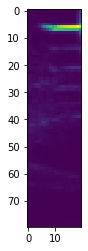

In [30]:
def test_one_char(data, idx, sample_rate = 16000):
    assert idx < len(data['chinese'])
    chinese = data['chinese'][idx]
    time = data['duration'][idx]
    duration = data['duration']
    for i in range(1, len(duration)):
        duration[i] += duration[i-1]
    start = 0 if idx == 0 else int(duration[idx-1]*sample_rate)
    end = int(duration[idx]*sample_rate)
    print(data['audio'].shape)
    waveform = data['audio'][0, start: end]
    print(duration)
    print(data['chinese'], chinese, time, ''.join(data['phoneme'][idx]))
    play(waveform)
    print('%.2f' % duration[0])

test_one_char(train_set[5], 3)

靠耳朵听，发现大部分的标注是准确的，也有小部分划分有点出入。
文本注音也有些问题，但是问题不大。

## Dataloader

这儿我们制作一个单个字的dataloader，包含拼音、音调、时常（量化后），延音。

之后使用lookup emb制作decoder的输入emb。这儿注意可以使用前一个字后一个字来辅助生成更好的声音。如果这样做，注意前一个字，本字，后一个字都需要使用不同的lookup table。

先做一个naive版本，前后一个字不考虑。即使如此，我们的dataloader任然需要提供所有信息。

In [31]:
print(train_set[0].keys())

dict_keys(['audio', 'text', 'chinese', 'phoneme', 'note', 'duration', 'slur'])


In [83]:
from torch.nn.utils.rnn import pad_sequence
class MusicLoaderGenerator:
    def __init__(self, 
        labels,
        num_workers=0,
        sample_rate = 22050,
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        ) -> None:
        self.phoneme_labels, self.note_labels, self.duration_labels, self.slur_labels = labels
        self.phoneme_look_up = {s: i for i, s in enumerate(self.phoneme_labels)}
        self.note_look_up = {s: i for i, s in enumerate(self.note_labels)}
        self.duration_look_up = {s: i for i, s in enumerate(self.duration_labels)}
        self.slur_look_up = {s: i for i, s in enumerate(self.slur_labels)}
        self.device = device
        self.num_workers = num_workers
        self.sample_rate = sample_rate
        self.mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
            n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
                f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
        self.version = '0.01'

    def label2id(self, look_up, str):
        if isinstance(str[0], list):
            return torch.stack([torch.tensor([look_up[i] for i in sub]) for sub in str])
        return torch.tensor([look_up[i] for i in str])

    def id2label(self, labels, idcs):
        return ''.join([labels[i] for i in idcs])

    def collate_wrapper(self, batch:list): # RAW
        bs = len(batch)
        sample_rate = self.sample_rate
        audio, audio_len, audio_duration, audio_duration_quant, chinese, phoneme,\
            phoneme_pre, phoneme_post, note, note_pre, note_post, slur,\
                mel, mel_len = [], [], [], [], [], [], [], [], [], [], [], [], [], []
        safe_log = lambda x: torch.log(x+2**(-15))
        for data in batch:
            audio_f = data['audio']
            chinese_f = data['chinese']
            phoneme_f = data['phoneme']
            note_f = data['note']
            duration_f = data['duration']
            duration_cum = duration_f.copy()
            for i in range(1, len(duration_cum)):
                duration_cum[i] += duration_cum[i-1]
            slur_f = data['slur']
            for i in range(len(chinese_f)):
                start = 0 if i == 0 else int(duration_cum[i-1]*sample_rate)
                end = int(duration_cum[i]*sample_rate)
                if (end-start<512):
                    continue
                wave_chunk = audio_f[0, start: end]
                audio.append(wave_chunk)
                audio_len.append(len(wave_chunk))
                audio_duration.append(duration_f[i])
                audio_duration_quant.append('%.2f' % duration_f[i])
                chinese.append(chinese_f[i])
                phoneme.append(phoneme_f[i])
                phoneme_pre.append(phoneme_f[i-1]if i>0 else ['SP', '-'])
                phoneme_post.append(phoneme_f[i+1]if i+1<len(phoneme_f) else ['SP', '-'])
                note.append(note_f[i])
                note_pre.append(note_f[i-1]if i>0 else 'rest')
                note_post.append(note_f[i+1]if i+1<len(note_f) else 'rest')
                slur.append(slur_f[i])
                mel_chunk = self.mel_transform(wave_chunk)
                mel.append(safe_log(mel_chunk).transpose(0,1))
                mel_len.append(mel_chunk.shape[-1])
        mel = pad_sequence(mel, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
        mel_len = torch.tensor(mel_len)
        
        return {
            'audio': audio,  # 单个字的raw音频
            'audio_len': audio_len, # 该音频数据长度
            'audio_duration': audio_duration, # 真实音屏时间长度
            'audio_duration_quant': audio_duration_quant, # 量化后音屏时间长度
            'chinese': chinese, # 该音频汉字
            'phoneme': self.label2id(self.phoneme_look_up, phoneme), # 拼音
            'phoneme_pre': self.label2id(self.phoneme_look_up, phoneme_pre), # 前一个汉字的拼音
            'phoneme_post': self.label2id(self.phoneme_look_up, phoneme_post), # 后一个汉字的拼音
            'note': self.label2id(self.note_look_up, note), # 音调音符
            'note_pre': self.label2id(self.note_look_up, note_pre),
            'note_post': self.label2id(self.note_look_up, note_post),
            'slur': self.label2id(self.slur_look_up, slur), # 是否为延长音
            'mel': mel,
            'mel_len': mel_len
            }

    def dataloader(self, audioDataset, batch_size, shuffle=True):
        # k_size is the kernel size for the encoder, for data augmentation
        self.threshold = audioDataset.dataset.threshold
        return DataLoader(audioDataset, batch_size,
                            shuffle, num_workers=self.num_workers, collate_fn=self.collate_wrapper)


In [84]:
from helper import get_pitch_labels
note_labels = get_pitch_labels()
slur_labels = [0, 1]
# 0-1 分辨率0.01，1-2 分辨率0.05，2-7 分辨率0.2
duration_labels = [i for i in range(7)] # max_note_duration is 6.x s, so we set max is 7

In [88]:
labels = (
    phoneme_labels,
    note_labels,
    duration_labels,
    slur_labels
)
loaderGenerator = MusicLoaderGenerator(labels)
train_loader = loaderGenerator.dataloader(train_set, batch_size=2)
print('train_set:', len(train_set), 'test_set:',len(test_set))
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    print(sample_batched['chinese'])
    print(sample_batched['phoneme'].shape)
    print(sample_batched['phoneme_pre'].shape)
    print(sample_batched['note_post'].shape)
    print(sample_batched['mel'].shape)
    print(sample_batched['mel_len'].shape, sample_batched['mel_len'])
    steps -= 1

train_set: 3744 test_set: 12
['期', 'SP', '待', '却', 'SP', '不', '知', '未', '来', '如', '何', '安', 'SP', '排', 'SP', 'AP', 'SP', '为', '梦', '想', '狂', '~', '~', 'AP', '都', '是', '戏', '里', 'SP', '编', '的', '谎', '话', 'SP', 'AP']
torch.Size([35, 2])
torch.Size([35, 2])
torch.Size([35])
torch.Size([35, 80, 79])
torch.Size([35]) tensor([19,  8, 17, 16, 10, 17, 22, 18, 23, 18, 23, 35,  7, 46, 28, 21,  5, 26,
        20, 24, 47, 38, 69, 44, 13, 24, 33, 19,  7, 33, 21, 34, 79, 36, 36])


## 使用解码器mel2audio

In [91]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()
''

Using cache found in /home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


''

torch.Size([1, 136932])
mel torch.Size([80, 167])
torch.Size([80, 167])
['一', '起', '看', '晚', '霞', '~', '满', '天', 'SP', 'AP'] 天 1.93721 tian


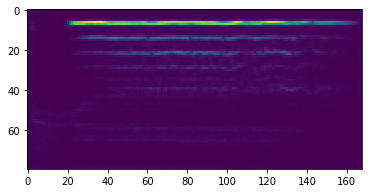

In [95]:
def test_one_char(data, idx, sample_rate = sample_rate):
    assert idx < len(data['chinese'])
    chinese = data['chinese'][idx]
    time = data['duration'][idx]
    duration = data['duration']
    for i in range(1, len(duration)):
        duration[i] += duration[i-1]
    start = 0 if idx == 0 else int(duration[idx-1]*sample_rate)
    end = int(duration[idx]*sample_rate)
    print(data['audio'].shape)
    waveform = data['audio'][0, start: end]
    play(waveform)
    
    mel = mel_transform(waveform)
    mel = torch.log(mel+2**(-15))
    # plt.imshow(mel.detach().numpy(), interpolation='none')
    print(mel.shape)
    # with torch.no_grad():
    waveforms = waveglow.infer(mel.unsqueeze(0))
    # plt.plot(waveforms[0].cpu().detach())
    plt.imshow(mel_transform(waveforms[0]).detach().numpy(), interpolation='none')
    print(data['chinese'], chinese, time, ''.join(data['phoneme'][idx]))
    torchaudio.save("my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=sample_rate)

test_one_char(train_set[5], 7)